In [1]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()

2024-04-29 19:18:02.829727: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 19:18:02.830084: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 19:18:02.833080: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 19:18:02.866706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 19:18:03.649543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import official.nlp.modeling.layers as nlp_layers

plt.rcParams.update({'font.size': 18})

In [3]:
print(tf.__version__)

2.16.1


In [4]:
def math_fun(x):
    x1=x[:,0]
    x2=x[:,1]
    g=((1.5+x1)**2+4)*(1.5+x2)/20-np.sin(5*(1.5+x1)/2)
    return g

### Prepare the training, testing and OOD data for the ML model
def make_data():
    mean_c1 = (8, 3.5)
    cov_c1 = [[0.4, -0.32], [-0.32, 0.4]]
    c1_sample_no = 500
    x_c1 = np.random.multivariate_normal(mean_c1, cov_c1, (c1_sample_no, 1)).reshape(c1_sample_no, 2)

    mean_c2 = (-2.5, -2.5)
    cov_c2 = [[0.4, -0.32], [-0.32, 0.4]]
    c2_sample_no = 500
    x_c2 = np.random.multivariate_normal(mean_c2, cov_c2, (c2_sample_no, 1)).reshape(c2_sample_no, 2)

    mean_ood = (-10, -7.5)
    cov_ood = [[0.2, -0.16], [-0.16, 0.2]]
    ood_sample_no = 200
    x_ood = np.random.multivariate_normal(mean_ood, cov_ood, (ood_sample_no, 1)).reshape(ood_sample_no, 2) 

    y_c1 = math_fun(x_c1).reshape(-1, 1)
    y_c2 = math_fun(x_c2).reshape(-1, 1)
    y_ood = math_fun(x_ood).reshape(-1, 1)

    ## Create train and test data for each cluster of data
    random_state = 1
    x_c1_train, x_c1_test, y_c1_train, y_c1_test = train_test_split(x_c1, y_c1, test_size=0.2, random_state=random_state)
    x_c2_train, x_c2_test, y_c2_train, y_c2_test = train_test_split(x_c2, y_c2, test_size=0.2, random_state=random_state)

    x_train = np.concatenate((x_c1_train, x_c2_train), axis = 0)
    x_test = np.concatenate((x_c1_test, x_c2_test), axis = 0)
    y_train = np.concatenate((y_c1_train, y_c2_train), axis = 0)
    y_test = np.concatenate((y_c1_test, y_c2_test), axis = 0)

    plt.figure(figsize=(10, 10))
    plt.scatter(x_c1_train[:, 0], x_c1_train[:, 1], color = 'red', marker = '+', label='1st cluster train')
    plt.scatter(x_c1_test[:, 0], x_c1_test[:, 1], color = 'red', marker = 'o', s = 8, label='1st cluster test')

    plt.scatter(x_c2_train[:, 0], x_c2_train[:, 1], color = 'blue', marker = '+', label='2nd cluster train')
    plt.scatter(x_c2_test[:, 0], x_c2_test[:, 1], color = 'blue', marker = 'o', s = 8, label='2nd cluster test')

    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'purple', label = 'OOD samples')

    plt.xlabel('X1', fontsize=22, fontweight='bold')
    plt.ylabel('X2', fontsize=22, fontweight='bold')
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18, fontweight='bold')

    plt.legend(fontsize=20)
    plt.axis('equal')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.tight_layout()

    plt.savefig('train_test_data.pdf')

    n_meshes = 100
    x1, x2 = np.meshgrid(np.linspace(-5, 0, n_meshes), np.linspace(-5, 0, n_meshes))
    x_mesh_1 = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis = 1)
    y_mesh_1 = math_fun(x_mesh_1).reshape(-1, 1).flatten()

    n_meshes = 100
    x1, x2 = np.meshgrid(np.linspace(5.5, 10.5, n_meshes), np.linspace(1, 6, n_meshes))
    x_mesh_2 = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis = 1)
    y_mesh_2 = math_fun(x_mesh_2).reshape(-1, 1).flatten()

    x_mesh = np.concatenate((x_mesh_1, x_mesh_2), axis = 0)
    y_mesh = np.concatenate((y_mesh_1, y_mesh_2), axis = 0)

    n_meshes = 200
    x1, x2 = np.meshgrid(np.linspace(-15, 15, n_meshes), np.linspace(-15, 15, n_meshes))
    x_mesh_full = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis = 1)
    y_mesh_full = math_fun(x_mesh_full).reshape(-1, 1).flatten()

    return x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh, x_mesh_full, y_mesh_full

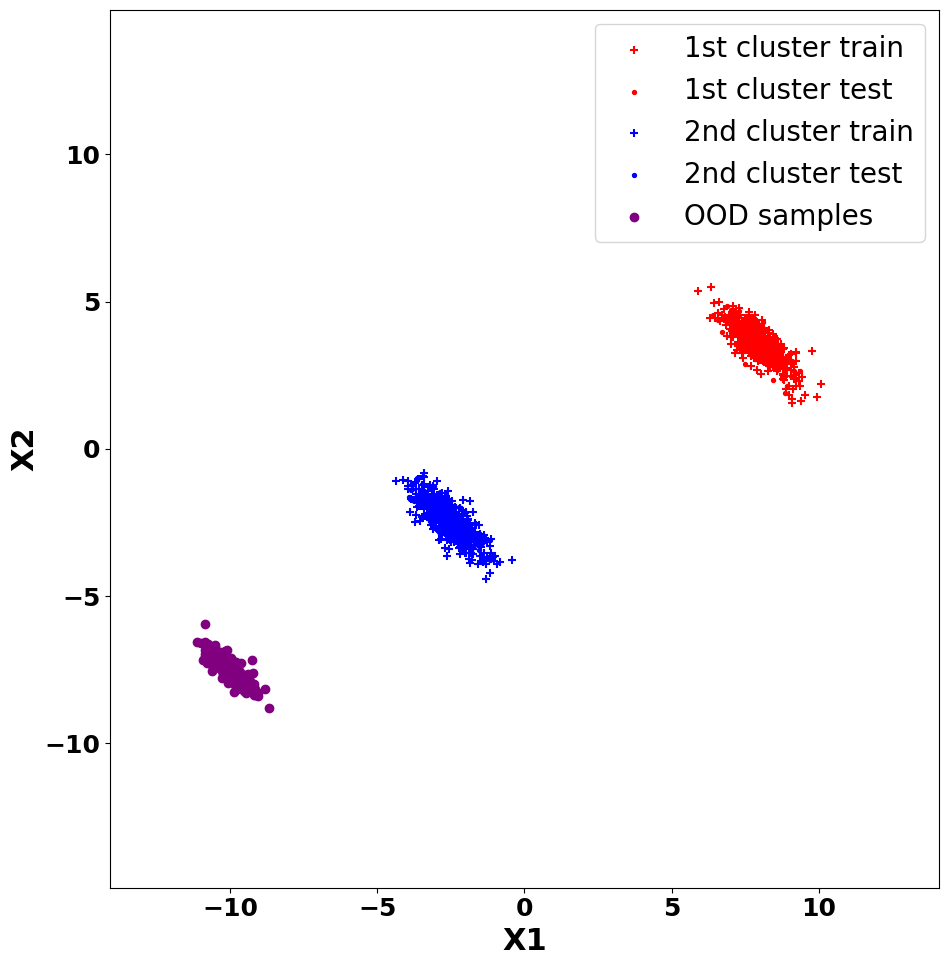

In [5]:
np.random.seed(1)
x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh, x_mesh_full, y_mesh_full = make_data()

## Common function definitions

In [6]:
#### Create figures to visualize the uncertainty produced by the ML model
def plot_uncertainty_map(x_train, x_ood, x_mesh, output_std, filename, spectral_normalization = False, contour=False):
    std_scaled = output_std/max(output_std)

    plt.figure(figsize=(10, 10))
    plt.rcParams['axes.xmargin'] = 0
    plt.rcParams['axes.ymargin'] = 0
    plt.scatter(x_mesh[:, 0], x_mesh[:, 1], rasterized = True, c = std_scaled, cmap = plt.get_cmap('viridis'))
    
    if spectral_normalization:
        cbar = plt.colorbar(fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=28)
        
    plt.scatter(x_train[:, 0], x_train[:, 1], color = 'magenta', s = 20, alpha = 0.7, label = 'Training')
    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'red', s = 20, alpha = 0.7, label = 'OOD')

    if contour:
        n = np.ceil(np.sqrt(len(std_scaled))).astype(int)
        h = std_scaled.reshape(n, n)
        contours = plt.contour(x_mesh[:, 0].reshape(n, n), x_mesh[:, 1].reshape(n, n), h)
        plt.clabel(contours, inline=True, fontsize=12)

        filename += '_with_contour'

    plt.legend(fontsize=20, loc=4)
    plt.xlabel(r'$x_1$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$x_2$', fontsize=40, fontweight='bold')
    plt.xticks(fontsize=36, fontweight='bold')
    plt.yticks(fontsize=36, fontweight='bold')

    plt.tight_layout()
    ax = plt.gca()
    ax.set_aspect('equal')

    plt.savefig(filename + '.pdf', bbox_inches='tight')

def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

# UQ model training

Each of the model has the following sequence:
- model functions/class definitions
- a single end-to-end run

## Uncertainty Model: SNGP

distance-aware based

 - spectral normalization from keras layers
 - gaussian process from gpflow, gpflux libraries

(inspiration from https://secondmind-labs.github.io/GPflux/notebooks/gpflux_with_keras_layers.html and https://www.tensorflow.org/tutorials/understanding/sngp)

In [7]:
class DeepResNet(tf.keras.Model):
    """Defines a multi-layer residual network."""
    def __init__(self, no_outputs, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **kwargs):
        super().__init__()
        # Defines class meta data.
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.kwargs = kwargs

        # Defines the hidden layers.
        self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
        self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

        # Defines the output layer.
        self.regressor = self.make_output_layer(no_outputs)

    def call(self, inputs):
        # Projects the 2d input data to high dimension.
        hidden = self.input_layer(inputs)

        # Computes the ResNet hidden representations.
        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
            hidden += resid

        return self.regressor(hidden)

    def make_dense_layer(self):
        """Uses the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(self.num_hidden, activation="relu")

    def make_output_layer(self, no_outputs):
        """Uses the Dense layer as the output layer."""
        return tf.keras.layers.Dense(
            no_outputs, **self.kwargs)

In [8]:
class DeepResNetSNGP(DeepResNet):
    def __init__(self, spec_norm_bound=0.9, spectral_normalization = True, **kwargs):
        self.spec_norm_bound = spec_norm_bound
        self.spectral_normalization = spectral_normalization
        super().__init__(**kwargs)

    def make_dense_layer(self):
        """Applies spectral normalization to the hidden layer."""
        dense_layer = super().make_dense_layer()

        if self.spectral_normalization:
            return nlp_layers.SpectralNormalization(
                dense_layer, norm_multiplier=self.spec_norm_bound)
        else:
            return dense_layer

    def make_output_layer(self, no_outputs):
        """Uses Gaussian process as the output layer."""
        if self.spectral_normalization:
            return nlp_layers.RandomFeatureGaussianProcess(
                no_outputs,
                gp_cov_momentum=-1,
                **self.kwargs)
        else:
            return nlp_layers.RandomFeatureGaussianProcess(
                no_outputs,
                gp_cov_momentum=-1,
                normalize_input = True,
                scale_random_features = True, 
                gp_kernel_scale_trainable = True,
                gp_output_bias_trainable = True, 
                **self.kwargs)

    def call(self, inputs, training=False, return_covmat=False):
        # Gets logits and a covariance matrix from the GP layer.
        mean, covmat = super().call(inputs)

        # Returns only logits during training.
        if not training and return_covmat:
            return mean, covmat

        return mean

In [9]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the beginning of the epoch."""
        if epoch > 0:
            self.model.regressor.reset_covariance_matrix()

In [10]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())

        return super().fit(*args, **kwargs)

In [11]:
def generate_trained_SNGPmodel(trainX, trainY, nepochs, spectral_normalization = True, actfn = 'relu', num_layers=2):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    model   - trained SNGP model
    """
    loss = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
    train_config = dict(loss=loss, optimizer=optimizer)
    resnet_config = dict(no_outputs=1, num_layers=4, num_hidden=128)
    fit_config = dict(batch_size=128, epochs=nepochs)
    
    model = DeepResNetSNGPWithCovReset(spectral_normalization=spectral_normalization, **resnet_config)
    
    model.compile(**train_config)
    model.fit(trainX, trainY, **fit_config)
    return model

In [12]:
spectral_normalization = True
nepochs = 6000
model = generate_trained_SNGPmodel(x_train, y_train, nepochs = nepochs, spectral_normalization = spectral_normalization)

2024-04-29 19:18:25.861815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 19:18:25.862052: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/6000
7/7 [==============================] - 14s 10ms/step - loss: 283.9833
Epoch 2/6000
7/7 [==============================] - 0s 9ms/step - loss: 283.9355
Epoch 3/6000
7/7 [==============================] - 0s 8ms/step - loss: 283.8847
Epoch 4/6000
7/7 [==============================] - 0s 8ms/step - loss: 283.8293
Epoch 5/6000
7/7 [==============================] - 0s 7ms/step - loss: 283.7726
Epoch 6/6000
7/7 [==============================] - 0s 6ms/step - loss: 283.9070
Epoch 7/6000
7/7 [==============================] - 0s 6ms/step - loss: 283.8363
Epoch 8/6000
7/7 [==============================] - 0s 6ms/step - loss: 283.7075
Epoch 9/6000
7/7 [==============================] - 0s 6ms/step - loss: 283.8349
Epoch 10/6000
7/7 [==============================] - 0s 7ms/step - loss: 283.7188
Epoch 11/6000
7/7 [==============================] - 0s 6ms/step - loss: 283.8132
Epoch 12/6000
7/7 [==============================] - 0s 6ms/step - loss: 283.7422
Epoch 13/6000
7/7 [====

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [13]:
sngp_mean, sngp_covmat = model(x_mesh_full, return_covmat=True)

In [14]:
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)

In [15]:
if spectral_normalization:
    model_name = 'SNGP_uncertainty'
else:
    model_name = 'DNNGP_uncertainty'

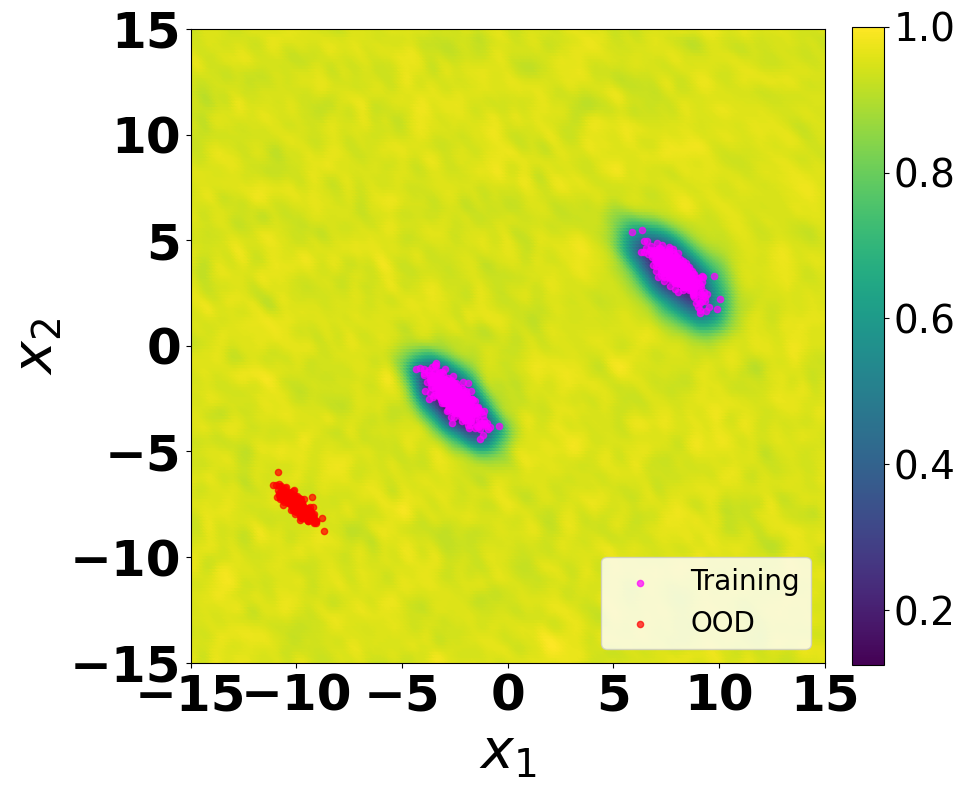

In [16]:
plot_uncertainty_map(x_train, x_ood, x_mesh_full, std, model_name, spectral_normalization, False)

## Uncertainty Model: DNNGP

SNGP without spectral normalization wrapper

In [17]:
spectral_normalization = False
DNNGP_model = generate_trained_SNGPmodel(x_train, y_train, nepochs = nepochs, spectral_normalization = spectral_normalization)

Epoch 1/6000
7/7 [==============================] - 2s 8ms/step - loss: 283.9729
Epoch 2/6000
7/7 [==============================] - 0s 7ms/step - loss: 283.9973
Epoch 3/6000
7/7 [==============================] - 0s 8ms/step - loss: 283.9608
Epoch 4/6000
7/7 [==============================] - 0s 7ms/step - loss: 283.8730
Epoch 5/6000
7/7 [==============================] - 0s 7ms/step - loss: 283.9935
Epoch 6/6000
7/7 [==============================] - 0s 8ms/step - loss: 283.8798
Epoch 7/6000
7/7 [==============================] - 0s 8ms/step - loss: 283.8869
Epoch 8/6000
7/7 [==============================] - 0s 8ms/step - loss: 283.8264
Epoch 9/6000
7/7 [==============================] - 0s 7ms/step - loss: 283.9045
Epoch 10/6000
7/7 [==============================] - 0s 8ms/step - loss: 283.9173
Epoch 11/6000
7/7 [==============================] - 0s 7ms/step - loss: 283.8893
Epoch 12/6000
7/7 [==============================] - 0s 7ms/step - loss: 283.7737
Epoch 13/6000
7/7 [======

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



7/7 [==============================] - 0s 3ms/step - loss: 279.2112
Epoch 298/6000
7/7 [==============================] - 0s 2ms/step - loss: 279.2014
Epoch 299/6000
7/7 [==============================] - 0s 6ms/step - loss: 279.1891
Epoch 300/6000
7/7 [==============================] - 0s 3ms/step - loss: 279.1235
Epoch 301/6000
7/7 [==============================] - 0s 3ms/step - loss: 279.1680
Epoch 302/6000
7/7 [==============================] - 0s 5ms/step - loss: 279.1542
Epoch 303/6000
7/7 [==============================] - 0s 2ms/step - loss: 279.1072
Epoch 304/6000
7/7 [==============================] - 0s 5ms/step - loss: 278.9288
Epoch 305/6000
7/7 [==============================] - 0s 2ms/step - loss: 279.1216
Epoch 306/6000
7/7 [==============================] - 0s 6ms/step - loss: 279.0241
Epoch 307/6000
7/7 [==============================] - 0s 3ms/step - loss: 278.9582
Epoch 308/6000
7/7 [==============================] - 0s 3ms/step - loss: 278.9493
Epoch 309/6000
7/7 

7/7 [==============================] - 0s 3ms/step - loss: 275.5473
Epoch 494/6000
7/7 [==============================] - 0s 5ms/step - loss: 275.3983
Epoch 495/6000
7/7 [==============================] - 0s 2ms/step - loss: 275.3897
Epoch 496/6000
7/7 [==============================] - 0s 6ms/step - loss: 275.3549
Epoch 497/6000
7/7 [==============================] - 0s 3ms/step - loss: 275.4338
Epoch 498/6000
7/7 [==============================] - 0s 3ms/step - loss: 275.3339
Epoch 499/6000
7/7 [==============================] - 0s 3ms/step - loss: 275.2937
Epoch 500/6000
7/7 [==============================] - 0s 3ms/step - loss: 275.2348
Epoch 501/6000
7/7 [==============================] - 0s 6ms/step - loss: 275.0904
Epoch 502/6000
7/7 [==============================] - 0s 2ms/step - loss: 275.2037
Epoch 503/6000
7/7 [==============================] - 0s 3ms/step - loss: 275.0179
Epoch 504/6000
7/7 [==============================] - 0s 3ms/step - loss: 275.1323
Epoch 505/6000
7/7 

7/7 [==============================] - 0s 2ms/step - loss: 251.3280
Epoch 690/6000
7/7 [==============================] - 0s 5ms/step - loss: 249.9872
Epoch 691/6000
7/7 [==============================] - 0s 3ms/step - loss: 250.1655
Epoch 692/6000
7/7 [==============================] - 0s 3ms/step - loss: 250.6663
Epoch 693/6000
7/7 [==============================] - 0s 6ms/step - loss: 250.7301
Epoch 694/6000
7/7 [==============================] - 0s 2ms/step - loss: 247.7225
Epoch 695/6000
7/7 [==============================] - 0s 6ms/step - loss: 248.0757
Epoch 696/6000
7/7 [==============================] - 0s 3ms/step - loss: 249.2021
Epoch 697/6000
7/7 [==============================] - 0s 3ms/step - loss: 248.6393
Epoch 698/6000
7/7 [==============================] - 0s 3ms/step - loss: 247.5169
Epoch 699/6000
7/7 [==============================] - 0s 3ms/step - loss: 247.3414
Epoch 700/6000
7/7 [==============================] - 0s 5ms/step - loss: 246.6886
Epoch 701/6000
7/7 

7/7 [==============================] - 0s 3ms/step - loss: 185.0503
Epoch 886/6000
7/7 [==============================] - 0s 5ms/step - loss: 181.2023
Epoch 887/6000
7/7 [==============================] - 0s 2ms/step - loss: 183.8997
Epoch 888/6000
7/7 [==============================] - 0s 5ms/step - loss: 174.2512
Epoch 889/6000
7/7 [==============================] - 0s 2ms/step - loss: 182.4690
Epoch 890/6000
7/7 [==============================] - 0s 3ms/step - loss: 180.0938
Epoch 891/6000
7/7 [==============================] - 0s 5ms/step - loss: 178.1869
Epoch 892/6000
7/7 [==============================] - 0s 2ms/step - loss: 178.0250
Epoch 893/6000
7/7 [==============================] - 0s 3ms/step - loss: 182.5979
Epoch 894/6000
7/7 [==============================] - 0s 3ms/step - loss: 173.8424
Epoch 895/6000
7/7 [==============================] - 0s 3ms/step - loss: 181.7216
Epoch 896/6000
7/7 [==============================] - 0s 3ms/step - loss: 174.3418
Epoch 897/6000
7/7 

7/7 [==============================] - 0s 3ms/step - loss: 130.4361
Epoch 1081/6000
7/7 [==============================] - 0s 2ms/step - loss: 139.5411
Epoch 1082/6000
7/7 [==============================] - 0s 5ms/step - loss: 126.0556
Epoch 1083/6000
7/7 [==============================] - 0s 2ms/step - loss: 126.0701
Epoch 1084/6000
7/7 [==============================] - 0s 5ms/step - loss: 128.6930
Epoch 1085/6000
7/7 [==============================] - 0s 2ms/step - loss: 120.5884
Epoch 1086/6000
7/7 [==============================] - 0s 5ms/step - loss: 129.1169
Epoch 1087/6000
7/7 [==============================] - 0s 3ms/step - loss: 127.4217
Epoch 1088/6000
7/7 [==============================] - 0s 5ms/step - loss: 129.4271
Epoch 1089/6000
7/7 [==============================] - 0s 2ms/step - loss: 131.9724
Epoch 1090/6000
7/7 [==============================] - 0s 5ms/step - loss: 131.6037
Epoch 1091/6000
7/7 [==============================] - 0s 2ms/step - loss: 129.5236
Epoch 10

7/7 [==============================] - 0s 2ms/step - loss: 101.4184
Epoch 1275/6000
7/7 [==============================] - 0s 5ms/step - loss: 100.7024
Epoch 1276/6000
7/7 [==============================] - 0s 3ms/step - loss: 95.9671
Epoch 1277/6000
7/7 [==============================] - 0s 3ms/step - loss: 93.3702
Epoch 1278/6000
7/7 [==============================] - 0s 3ms/step - loss: 105.2719
Epoch 1279/6000
7/7 [==============================] - 0s 3ms/step - loss: 97.0312
Epoch 1280/6000
7/7 [==============================] - 0s 5ms/step - loss: 100.3517
Epoch 1281/6000
7/7 [==============================] - 0s 3ms/step - loss: 103.1392
Epoch 1282/6000
7/7 [==============================] - 0s 3ms/step - loss: 98.0269
Epoch 1283/6000
7/7 [==============================] - 0s 3ms/step - loss: 102.5445
Epoch 1284/6000
7/7 [==============================] - 0s 2ms/step - loss: 96.3513
Epoch 1285/6000
7/7 [==============================] - 0s 3ms/step - loss: 105.6590
Epoch 1286/60

7/7 [==============================] - 0s 3ms/step - loss: 77.8037
Epoch 1471/6000
7/7 [==============================] - 0s 5ms/step - loss: 80.2723
Epoch 1472/6000
7/7 [==============================] - 0s 3ms/step - loss: 83.9447
Epoch 1473/6000
7/7 [==============================] - 0s 3ms/step - loss: 83.7298
Epoch 1474/6000
7/7 [==============================] - 0s 3ms/step - loss: 85.8507
Epoch 1475/6000
7/7 [==============================] - 0s 2ms/step - loss: 79.4087
Epoch 1476/6000
7/7 [==============================] - 0s 3ms/step - loss: 84.1705
Epoch 1477/6000
7/7 [==============================] - 0s 2ms/step - loss: 81.4921
Epoch 1478/6000
7/7 [==============================] - 0s 3ms/step - loss: 81.9382
Epoch 1479/6000
7/7 [==============================] - 0s 2ms/step - loss: 80.7118
Epoch 1480/6000
7/7 [==============================] - 0s 5ms/step - loss: 76.7675
Epoch 1481/6000
7/7 [==============================] - 0s 2ms/step - loss: 77.6806
Epoch 1482/6000
7/7 

7/7 [==============================] - 0s 2ms/step - loss: 60.8795
Epoch 1667/6000
7/7 [==============================] - 0s 5ms/step - loss: 53.6659
Epoch 1668/6000
7/7 [==============================] - 0s 2ms/step - loss: 59.9901
Epoch 1669/6000
7/7 [==============================] - 0s 6ms/step - loss: 60.5050
Epoch 1670/6000
7/7 [==============================] - 0s 3ms/step - loss: 51.7467
Epoch 1671/6000
7/7 [==============================] - 0s 3ms/step - loss: 54.1371
Epoch 1672/6000
7/7 [==============================] - 0s 3ms/step - loss: 55.0454
Epoch 1673/6000
7/7 [==============================] - 0s 3ms/step - loss: 53.0321
Epoch 1674/6000
7/7 [==============================] - 0s 3ms/step - loss: 51.5654
Epoch 1675/6000
7/7 [==============================] - 0s 3ms/step - loss: 60.9135
Epoch 1676/6000
7/7 [==============================] - 0s 3ms/step - loss: 54.6783
Epoch 1677/6000
7/7 [==============================] - 0s 2ms/step - loss: 56.9074
Epoch 1678/6000
7/7 

7/7 [==============================] - 0s 3ms/step - loss: 39.0509
Epoch 1863/6000
7/7 [==============================] - 0s 2ms/step - loss: 36.9036
Epoch 1864/6000
7/7 [==============================] - 0s 3ms/step - loss: 52.1754
Epoch 1865/6000
7/7 [==============================] - 0s 3ms/step - loss: 41.1122
Epoch 1866/6000
7/7 [==============================] - 0s 5ms/step - loss: 41.6957
Epoch 1867/6000
7/7 [==============================] - 0s 2ms/step - loss: 38.0742
Epoch 1868/6000
7/7 [==============================] - 0s 5ms/step - loss: 44.3451
Epoch 1869/6000
7/7 [==============================] - 0s 2ms/step - loss: 42.2914
Epoch 1870/6000
7/7 [==============================] - 0s 3ms/step - loss: 45.3405
Epoch 1871/6000
7/7 [==============================] - 0s 3ms/step - loss: 34.6927
Epoch 1872/6000
7/7 [==============================] - 0s 3ms/step - loss: 45.4851
Epoch 1873/6000
7/7 [==============================] - 0s 3ms/step - loss: 42.6061
Epoch 1874/6000
7/7 

7/7 [==============================] - 0s 3ms/step - loss: 36.4767
Epoch 2059/6000
7/7 [==============================] - 0s 3ms/step - loss: 38.3917
Epoch 2060/6000
7/7 [==============================] - 0s 6ms/step - loss: 39.9706
Epoch 2061/6000
7/7 [==============================] - 0s 2ms/step - loss: 27.6142
Epoch 2062/6000
7/7 [==============================] - 0s 5ms/step - loss: 32.8853
Epoch 2063/6000
7/7 [==============================] - 0s 2ms/step - loss: 34.2673
Epoch 2064/6000
7/7 [==============================] - 0s 5ms/step - loss: 35.0826
Epoch 2065/6000
7/7 [==============================] - 0s 2ms/step - loss: 36.3042
Epoch 2066/6000
7/7 [==============================] - 0s 3ms/step - loss: 35.3197
Epoch 2067/6000
7/7 [==============================] - 0s 3ms/step - loss: 33.3813
Epoch 2068/6000
7/7 [==============================] - 0s 2ms/step - loss: 34.1065
Epoch 2069/6000
7/7 [==============================] - 0s 3ms/step - loss: 37.4704
Epoch 2070/6000
7/7 

7/7 [==============================] - 0s 3ms/step - loss: 28.8649
Epoch 2255/6000
7/7 [==============================] - 0s 3ms/step - loss: 30.8268
Epoch 2256/6000
7/7 [==============================] - 0s 3ms/step - loss: 28.5371
Epoch 2257/6000
7/7 [==============================] - 0s 3ms/step - loss: 23.9232
Epoch 2258/6000
7/7 [==============================] - 0s 3ms/step - loss: 23.9697
Epoch 2259/6000
7/7 [==============================] - 0s 3ms/step - loss: 25.9617
Epoch 2260/6000
7/7 [==============================] - 0s 3ms/step - loss: 27.0987
Epoch 2261/6000
7/7 [==============================] - 0s 3ms/step - loss: 25.4489
Epoch 2262/6000
7/7 [==============================] - 0s 3ms/step - loss: 27.3151
Epoch 2263/6000
7/7 [==============================] - 0s 3ms/step - loss: 27.9998
Epoch 2264/6000
7/7 [==============================] - 0s 3ms/step - loss: 24.2748
Epoch 2265/6000
7/7 [==============================] - 0s 3ms/step - loss: 26.0462
Epoch 2266/6000
7/7 

7/7 [==============================] - 0s 3ms/step - loss: 23.0953
Epoch 2451/6000
7/7 [==============================] - 0s 5ms/step - loss: 20.9682
Epoch 2452/6000
7/7 [==============================] - 0s 3ms/step - loss: 21.3123
Epoch 2453/6000
7/7 [==============================] - 0s 6ms/step - loss: 21.4810
Epoch 2454/6000
7/7 [==============================] - 0s 4ms/step - loss: 26.1626
Epoch 2455/6000
7/7 [==============================] - 0s 4ms/step - loss: 23.9063
Epoch 2456/6000
7/7 [==============================] - 0s 2ms/step - loss: 24.2629
Epoch 2457/6000
7/7 [==============================] - 0s 5ms/step - loss: 23.8524
Epoch 2458/6000
7/7 [==============================] - 0s 2ms/step - loss: 24.8661
Epoch 2459/6000
7/7 [==============================] - 0s 5ms/step - loss: 26.6496
Epoch 2460/6000
7/7 [==============================] - 0s 2ms/step - loss: 20.4418
Epoch 2461/6000
7/7 [==============================] - 0s 3ms/step - loss: 21.0830
Epoch 2462/6000
7/7 

7/7 [==============================] - 0s 5ms/step - loss: 17.2741
Epoch 2647/6000
7/7 [==============================] - 0s 2ms/step - loss: 15.1893
Epoch 2648/6000
7/7 [==============================] - 0s 6ms/step - loss: 16.1446
Epoch 2649/6000
7/7 [==============================] - 0s 3ms/step - loss: 16.6069
Epoch 2650/6000
7/7 [==============================] - 0s 3ms/step - loss: 15.2029
Epoch 2651/6000
7/7 [==============================] - 0s 3ms/step - loss: 17.0766
Epoch 2652/6000
7/7 [==============================] - 0s 2ms/step - loss: 16.3181
Epoch 2653/6000
7/7 [==============================] - 0s 6ms/step - loss: 17.7997
Epoch 2654/6000
7/7 [==============================] - 0s 3ms/step - loss: 16.9996
Epoch 2655/6000
7/7 [==============================] - 0s 3ms/step - loss: 16.1779
Epoch 2656/6000
7/7 [==============================] - 0s 3ms/step - loss: 18.7972
Epoch 2657/6000
7/7 [==============================] - 0s 4ms/step - loss: 15.8068
Epoch 2658/6000
7/7 

7/7 [==============================] - 0s 3ms/step - loss: 12.8258
Epoch 2843/6000
7/7 [==============================] - 0s 6ms/step - loss: 14.3604
Epoch 2844/6000
7/7 [==============================] - 0s 2ms/step - loss: 13.1172
Epoch 2845/6000
7/7 [==============================] - 0s 3ms/step - loss: 13.7686
Epoch 2846/6000
7/7 [==============================] - 0s 2ms/step - loss: 11.4195
Epoch 2847/6000
7/7 [==============================] - 0s 6ms/step - loss: 10.1024
Epoch 2848/6000
7/7 [==============================] - 0s 3ms/step - loss: 12.4122
Epoch 2849/6000
7/7 [==============================] - 0s 3ms/step - loss: 10.2220
Epoch 2850/6000
7/7 [==============================] - 0s 3ms/step - loss: 11.4366
Epoch 2851/6000
7/7 [==============================] - 0s 3ms/step - loss: 13.0257
Epoch 2852/6000
7/7 [==============================] - 0s 3ms/step - loss: 13.6323
Epoch 2853/6000
7/7 [==============================] - 0s 3ms/step - loss: 12.1194
Epoch 2854/6000
7/7 

Epoch 2941/6000
7/7 [==============================] - 0s 5ms/step - loss: 10.0886
Epoch 2942/6000
7/7 [==============================] - 0s 3ms/step - loss: 8.3550
Epoch 2943/6000
7/7 [==============================] - 0s 3ms/step - loss: 12.2075
Epoch 2944/6000
7/7 [==============================] - 0s 3ms/step - loss: 12.0021
Epoch 2945/6000
7/7 [==============================] - 0s 2ms/step - loss: 9.8479
Epoch 2946/6000
7/7 [==============================] - 0s 3ms/step - loss: 13.5217
Epoch 2947/6000
7/7 [==============================] - 0s 5ms/step - loss: 12.3856
Epoch 2948/6000
7/7 [==============================] - 0s 2ms/step - loss: 12.5721
Epoch 2949/6000
7/7 [==============================] - 0s 3ms/step - loss: 11.3434
Epoch 2950/6000
7/7 [==============================] - 0s 3ms/step - loss: 10.1188
Epoch 2951/6000
7/7 [==============================] - 0s 3ms/step - loss: 11.8587
Epoch 2952/6000
7/7 [==============================] - 0s 6ms/step - loss: 8.6091
Epoch 2

7/7 [==============================] - 0s 2ms/step - loss: 7.6598
Epoch 3041/6000
7/7 [==============================] - 0s 3ms/step - loss: 13.5192
Epoch 3042/6000
7/7 [==============================] - 0s 3ms/step - loss: 11.0074
Epoch 3043/6000
7/7 [==============================] - 0s 3ms/step - loss: 9.8611
Epoch 3044/6000
7/7 [==============================] - 0s 6ms/step - loss: 10.1596
Epoch 3045/6000
7/7 [==============================] - 0s 2ms/step - loss: 9.8528
Epoch 3046/6000
7/7 [==============================] - 0s 3ms/step - loss: 9.8323
Epoch 3047/6000
7/7 [==============================] - 0s 6ms/step - loss: 12.4943
Epoch 3048/6000
7/7 [==============================] - 0s 4ms/step - loss: 8.2380
Epoch 3049/6000
7/7 [==============================] - 0s 4ms/step - loss: 9.0869
Epoch 3050/6000
7/7 [==============================] - 0s 2ms/step - loss: 12.7887
Epoch 3051/6000
7/7 [==============================] - 0s 3ms/step - loss: 9.1073
Epoch 3052/6000
7/7 [======

7/7 [==============================] - 0s 4ms/step - loss: 8.2183
Epoch 3239/6000
7/7 [==============================] - 0s 5ms/step - loss: 6.4412
Epoch 3240/6000
7/7 [==============================] - 0s 4ms/step - loss: 6.7490
Epoch 3241/6000
7/7 [==============================] - 0s 2ms/step - loss: 6.6002
Epoch 3242/6000
7/7 [==============================] - 0s 3ms/step - loss: 8.0421
Epoch 3243/6000
7/7 [==============================] - 0s 6ms/step - loss: 7.8722
Epoch 3244/6000
7/7 [==============================] - 0s 6ms/step - loss: 4.8769
Epoch 3245/6000
7/7 [==============================] - 0s 4ms/step - loss: 7.5684
Epoch 3246/6000
7/7 [==============================] - 0s 2ms/step - loss: 9.6146
Epoch 3247/6000
7/7 [==============================] - 0s 3ms/step - loss: 9.0617
Epoch 3248/6000
7/7 [==============================] - 0s 2ms/step - loss: 10.0224
Epoch 3249/6000
7/7 [==============================] - 0s 3ms/step - loss: 8.8547
Epoch 3250/6000
7/7 [==========

7/7 [==============================] - 0s 3ms/step - loss: 6.9037
Epoch 3339/6000
7/7 [==============================] - 0s 5ms/step - loss: 8.2028
Epoch 3340/6000
7/7 [==============================] - 0s 2ms/step - loss: 6.9651
Epoch 3341/6000
7/7 [==============================] - 0s 5ms/step - loss: 8.4657
Epoch 3342/6000
7/7 [==============================] - 0s 2ms/step - loss: 8.0553
Epoch 3343/6000
7/7 [==============================] - 0s 6ms/step - loss: 8.3566
Epoch 3344/6000
7/7 [==============================] - 0s 3ms/step - loss: 8.4529
Epoch 3345/6000
7/7 [==============================] - 0s 3ms/step - loss: 6.4417
Epoch 3346/6000
7/7 [==============================] - 0s 3ms/step - loss: 7.6820
Epoch 3347/6000
7/7 [==============================] - 0s 5ms/step - loss: 6.3751
Epoch 3348/6000
7/7 [==============================] - 0s 3ms/step - loss: 7.5535
Epoch 3349/6000
7/7 [==============================] - 0s 3ms/step - loss: 10.0713
Epoch 3350/6000
7/7 [==========

7/7 [==============================] - 0s 3ms/step - loss: 6.3219
Epoch 3439/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.7720
Epoch 3440/6000
7/7 [==============================] - 0s 3ms/step - loss: 6.7910
Epoch 3441/6000
7/7 [==============================] - 0s 3ms/step - loss: 8.4816
Epoch 3442/6000
7/7 [==============================] - 0s 6ms/step - loss: 7.1185
Epoch 3443/6000
7/7 [==============================] - 0s 4ms/step - loss: 8.4510
Epoch 3444/6000
7/7 [==============================] - 0s 5ms/step - loss: 6.8729
Epoch 3445/6000
7/7 [==============================] - 0s 4ms/step - loss: 5.6140
Epoch 3446/6000
7/7 [==============================] - 0s 3ms/step - loss: 7.2534
Epoch 3447/6000
7/7 [==============================] - 0s 3ms/step - loss: 6.2206
Epoch 3448/6000
7/7 [==============================] - 0s 3ms/step - loss: 7.1379
Epoch 3449/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.1805
Epoch 3450/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 5.5982
Epoch 3539/6000
7/7 [==============================] - 0s 5ms/step - loss: 5.9958
Epoch 3540/6000
7/7 [==============================] - 0s 3ms/step - loss: 7.2922
Epoch 3541/6000
7/7 [==============================] - 0s 5ms/step - loss: 6.8146
Epoch 3542/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.6651
Epoch 3543/6000
7/7 [==============================] - 0s 5ms/step - loss: 7.0718
Epoch 3544/6000
7/7 [==============================] - 0s 2ms/step - loss: 5.8524
Epoch 3545/6000
7/7 [==============================] - 0s 5ms/step - loss: 5.6736
Epoch 3546/6000
7/7 [==============================] - 0s 2ms/step - loss: 5.9137
Epoch 3547/6000
7/7 [==============================] - 0s 5ms/step - loss: 5.2676
Epoch 3548/6000
7/7 [==============================] - 0s 2ms/step - loss: 6.8498
Epoch 3549/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.3276
Epoch 3550/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 5.6541
Epoch 3639/6000
7/7 [==============================] - 0s 3ms/step - loss: 6.3223
Epoch 3640/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.9942
Epoch 3641/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.7128
Epoch 3642/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.7351
Epoch 3643/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.8250
Epoch 3644/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.3073
Epoch 3645/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.6317
Epoch 3646/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.2761
Epoch 3647/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.4867
Epoch 3648/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.7957
Epoch 3649/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.8064
Epoch 3650/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 4.6086
Epoch 3739/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.9680
Epoch 3740/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.2703
Epoch 3741/6000
7/7 [==============================] - 0s 5ms/step - loss: 5.6979
Epoch 3742/6000
7/7 [==============================] - 0s 2ms/step - loss: 5.5293
Epoch 3743/6000
7/7 [==============================] - 0s 5ms/step - loss: 4.8069
Epoch 3744/6000
7/7 [==============================] - 0s 2ms/step - loss: 5.0062
Epoch 3745/6000
7/7 [==============================] - 0s 5ms/step - loss: 4.3248
Epoch 3746/6000
7/7 [==============================] - 0s 2ms/step - loss: 5.6536
Epoch 3747/6000
7/7 [==============================] - 0s 3ms/step - loss: 6.7420
Epoch 3748/6000
7/7 [==============================] - 0s 6ms/step - loss: 5.6677
Epoch 3749/6000
7/7 [==============================] - 0s 2ms/step - loss: 6.3702
Epoch 3750/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 5.1073
Epoch 3839/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.5922
Epoch 3840/6000
7/7 [==============================] - 0s 6ms/step - loss: 6.1306
Epoch 3841/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.0851
Epoch 3842/6000
7/7 [==============================] - 0s 5ms/step - loss: 5.4177
Epoch 3843/6000
7/7 [==============================] - 0s 2ms/step - loss: 4.1325
Epoch 3844/6000
7/7 [==============================] - 0s 6ms/step - loss: 4.7842
Epoch 3845/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.1017
Epoch 3846/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.2030
Epoch 3847/6000
7/7 [==============================] - 0s 6ms/step - loss: 5.0314
Epoch 3848/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.8912
Epoch 3849/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.5872
Epoch 3850/6000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 3.4129
Epoch 3939/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.9152
Epoch 3940/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.5215
Epoch 3941/6000
7/7 [==============================] - 0s 5ms/step - loss: 4.9408
Epoch 3942/6000
7/7 [==============================] - 0s 2ms/step - loss: 4.9533
Epoch 3943/6000
7/7 [==============================] - 0s 6ms/step - loss: 4.0217
Epoch 3944/6000
7/7 [==============================] - 0s 4ms/step - loss: 5.1525
Epoch 3945/6000
7/7 [==============================] - 0s 4ms/step - loss: 3.6343
Epoch 3946/6000
7/7 [==============================] - 0s 2ms/step - loss: 5.1130
Epoch 3947/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.5544
Epoch 3948/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.8070
Epoch 3949/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.1109
Epoch 3950/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 6.0793
Epoch 4039/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.3686
Epoch 4040/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.6951
Epoch 4041/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.9098
Epoch 4042/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.7698
Epoch 4043/6000
7/7 [==============================] - 0s 4ms/step - loss: 5.1652
Epoch 4044/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.7418
Epoch 4045/6000
7/7 [==============================] - 0s 3ms/step - loss: 5.1514
Epoch 4046/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.1042
Epoch 4047/6000
7/7 [==============================] - 0s 5ms/step - loss: 4.4332
Epoch 4048/6000
7/7 [==============================] - 0s 2ms/step - loss: 4.2776
Epoch 4049/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.7324
Epoch 4050/6000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 4.3864
Epoch 4139/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.8532
Epoch 4140/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.2364
Epoch 4141/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.1848
Epoch 4142/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.5735
Epoch 4143/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.6781
Epoch 4144/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.4247
Epoch 4145/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.2845
Epoch 4146/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.9094
Epoch 4147/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.6025
Epoch 4148/6000
7/7 [==============================] - 0s 6ms/step - loss: 4.4951
Epoch 4149/6000
7/7 [==============================] - 0s 4ms/step - loss: 4.1243
Epoch 4150/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 2.8070
Epoch 4239/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.6492
Epoch 4240/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.9087
Epoch 4241/6000
7/7 [==============================] - 0s 2ms/step - loss: 4.3207
Epoch 4242/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.8843
Epoch 4243/6000
7/7 [==============================] - 0s 5ms/step - loss: 4.2591
Epoch 4244/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.7424
Epoch 4245/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.9596
Epoch 4246/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.4056
Epoch 4247/6000
7/7 [==============================] - 0s 2ms/step - loss: 4.1573
Epoch 4248/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.4898
Epoch 4249/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.9934
Epoch 4250/6000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 4.3068
Epoch 4339/6000
7/7 [==============================] - 0s 6ms/step - loss: 3.4386
Epoch 4340/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.4336
Epoch 4341/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.5761
Epoch 4342/6000
7/7 [==============================] - 0s 6ms/step - loss: 3.6905
Epoch 4343/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.3184
Epoch 4344/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.9434
Epoch 4345/6000
7/7 [==============================] - 0s 5ms/step - loss: 4.0091
Epoch 4346/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.9996
Epoch 4347/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.1498
Epoch 4348/6000
7/7 [==============================] - 0s 2ms/step - loss: 5.0552
Epoch 4349/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.9031
Epoch 4350/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 3.8407
Epoch 4439/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.7428
Epoch 4440/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.6621
Epoch 4441/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.6713
Epoch 4442/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.3670
Epoch 4443/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.0899
Epoch 4444/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.7069
Epoch 4445/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.2468
Epoch 4446/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.9939
Epoch 4447/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.6766
Epoch 4448/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.4825
Epoch 4449/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.5649
Epoch 4450/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 3.4382
Epoch 4539/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.4710
Epoch 4540/6000
7/7 [==============================] - 0s 2ms/step - loss: 4.4285
Epoch 4541/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.1928
Epoch 4542/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.7399
Epoch 4543/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.3592
Epoch 4544/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.7678
Epoch 4545/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.4994
Epoch 4546/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.9931
Epoch 4547/6000
7/7 [==============================] - 0s 6ms/step - loss: 3.4309
Epoch 4548/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.9339
Epoch 4549/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.9041
Epoch 4550/6000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 3.1305
Epoch 4639/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.4627
Epoch 4640/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.6471
Epoch 4641/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.7344
Epoch 4642/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.0843
Epoch 4643/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.9154
Epoch 4644/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.6273
Epoch 4645/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.9558
Epoch 4646/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.1095
Epoch 4647/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.8868
Epoch 4648/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.8986
Epoch 4649/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.7080
Epoch 4650/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 3.4133
Epoch 4739/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.5807
Epoch 4740/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.9645
Epoch 4741/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.2563
Epoch 4742/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.4229
Epoch 4743/6000
7/7 [==============================] - 0s 2ms/step - loss: 4.0590
Epoch 4744/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.1224
Epoch 4745/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.3598
Epoch 4746/6000
7/7 [==============================] - 0s 4ms/step - loss: 2.9316
Epoch 4747/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.4821
Epoch 4748/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.9699
Epoch 4749/6000
7/7 [==============================] - 0s 6ms/step - loss: 3.6667
Epoch 4750/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 3.1205
Epoch 4839/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.5901
Epoch 4840/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.7673
Epoch 4841/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.3615
Epoch 4842/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.6724
Epoch 4843/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.2946
Epoch 4844/6000
7/7 [==============================] - 0s 6ms/step - loss: 3.4127
Epoch 4845/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.2960
Epoch 4846/6000
7/7 [==============================] - 0s 6ms/step - loss: 3.1136
Epoch 4847/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.0221
Epoch 4848/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.0014
Epoch 4849/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.9291
Epoch 4850/6000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 3.0593
Epoch 4939/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.4557
Epoch 4940/6000
7/7 [==============================] - 0s 3ms/step - loss: 4.2817
Epoch 4941/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.8942
Epoch 4942/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.9491
Epoch 4943/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.3268
Epoch 4944/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.3467
Epoch 4945/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.7885
Epoch 4946/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.1345
Epoch 4947/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.3742
Epoch 4948/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.4077
Epoch 4949/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.7529
Epoch 4950/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 2.3368
Epoch 5039/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.1266
Epoch 5040/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.3976
Epoch 5041/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.1623
Epoch 5042/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.2359
Epoch 5043/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.9780
Epoch 5044/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.2359
Epoch 5045/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.3088
Epoch 5046/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.2850
Epoch 5047/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.8787
Epoch 5048/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.3869
Epoch 5049/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.6221
Epoch 5050/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 3.2407
Epoch 5139/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.1846
Epoch 5140/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.1802
Epoch 5141/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.5091
Epoch 5142/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.7718
Epoch 5143/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.5461
Epoch 5144/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.9004
Epoch 5145/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.2517
Epoch 5146/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.1105
Epoch 5147/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.6750
Epoch 5148/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.2002
Epoch 5149/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.7383
Epoch 5150/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 2.9068
Epoch 5239/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.4487
Epoch 5240/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.1193
Epoch 5241/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.1757
Epoch 5242/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.8733
Epoch 5243/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.7403
Epoch 5244/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.7887
Epoch 5245/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.6698
Epoch 5246/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.8245
Epoch 5247/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.4130
Epoch 5248/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.4346
Epoch 5249/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.5415
Epoch 5250/6000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 2.9281
Epoch 5339/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.8265
Epoch 5340/6000
7/7 [==============================] - 0s 6ms/step - loss: 1.9897
Epoch 5341/6000
7/7 [==============================] - 0s 5ms/step - loss: 3.1432
Epoch 5342/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.2831
Epoch 5343/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.6339
Epoch 5344/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.4353
Epoch 5345/6000
7/7 [==============================] - 0s 2ms/step - loss: 3.5202
Epoch 5346/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.2649
Epoch 5347/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.8329
Epoch 5348/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.9417
Epoch 5349/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.0809
Epoch 5350/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 2.4893
Epoch 5439/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.6715
Epoch 5440/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.5344
Epoch 5441/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.3005
Epoch 5442/6000
7/7 [==============================] - 0s 3ms/step - loss: 3.2713
Epoch 5443/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.2424
Epoch 5444/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.4957
Epoch 5445/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.3231
Epoch 5446/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.2429
Epoch 5447/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.3362
Epoch 5448/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.5637
Epoch 5449/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.5031
Epoch 5450/6000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 2.9797
Epoch 5539/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.0329
Epoch 5540/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.2967
Epoch 5541/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.3976
Epoch 5542/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.5032
Epoch 5543/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.6316
Epoch 5544/6000
7/7 [==============================] - 0s 5ms/step - loss: 1.8297
Epoch 5545/6000
7/7 [==============================] - 0s 2ms/step - loss: 1.6717
Epoch 5546/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.0826
Epoch 5547/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.6543
Epoch 5548/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.6468
Epoch 5549/6000
7/7 [==============================] - 0s 3ms/step - loss: 1.8638
Epoch 5550/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 1.6942
Epoch 5639/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.1896
Epoch 5640/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.4339
Epoch 5641/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.0959
Epoch 5642/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.2205
Epoch 5643/6000
7/7 [==============================] - 0s 5ms/step - loss: 1.8055
Epoch 5644/6000
7/7 [==============================] - 0s 2ms/step - loss: 1.7913
Epoch 5645/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.2276
Epoch 5646/6000
7/7 [==============================] - 0s 5ms/step - loss: 1.8623
Epoch 5647/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.3519
Epoch 5648/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.1816
Epoch 5649/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.1829
Epoch 5650/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 2.7427
Epoch 5739/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.2550
Epoch 5740/6000
7/7 [==============================] - 0s 1ms/step - loss: 2.5651
Epoch 5741/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.1460
Epoch 5742/6000
7/7 [==============================] - 0s 5ms/step - loss: 1.9872
Epoch 5743/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.1538
Epoch 5744/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.0223
Epoch 5745/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.4423
Epoch 5746/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.3439
Epoch 5747/6000
7/7 [==============================] - 0s 3ms/step - loss: 1.9333
Epoch 5748/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.2303
Epoch 5749/6000
7/7 [==============================] - 0s 2ms/step - loss: 1.7183
Epoch 5750/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 1.8747
Epoch 5839/6000
7/7 [==============================] - 0s 5ms/step - loss: 1.9680
Epoch 5840/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.6474
Epoch 5841/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.0902
Epoch 5842/6000
7/7 [==============================] - 0s 5ms/step - loss: 1.7335
Epoch 5843/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.2268
Epoch 5844/6000
7/7 [==============================] - 0s 5ms/step - loss: 1.8729
Epoch 5845/6000
7/7 [==============================] - 0s 4ms/step - loss: 1.9873
Epoch 5846/6000
7/7 [==============================] - 0s 5ms/step - loss: 1.7272
Epoch 5847/6000
7/7 [==============================] - 0s 2ms/step - loss: 1.7381
Epoch 5848/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.0318
Epoch 5849/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.5420
Epoch 5850/6000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 1.9583
Epoch 5939/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.9544
Epoch 5940/6000
7/7 [==============================] - 0s 6ms/step - loss: 1.7556
Epoch 5941/6000
7/7 [==============================] - 0s 3ms/step - loss: 1.8660
Epoch 5942/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.0667
Epoch 5943/6000
7/7 [==============================] - 0s 5ms/step - loss: 2.1867
Epoch 5944/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.2106
Epoch 5945/6000
7/7 [==============================] - 0s 3ms/step - loss: 2.3501
Epoch 5946/6000
7/7 [==============================] - 0s 5ms/step - loss: 1.5723
Epoch 5947/6000
7/7 [==============================] - 0s 2ms/step - loss: 2.0852
Epoch 5948/6000
7/7 [==============================] - 0s 3ms/step - loss: 1.6661
Epoch 5949/6000
7/7 [==============================] - 0s 6ms/step - loss: 2.5949
Epoch 5950/6000
7/7 [===========

In [18]:
dnngp_mean, dnngp_covmat = DNNGP_model(x_mesh_full, return_covmat=True)

In [19]:
dnngp_variance = tf.linalg.diag_part(dnngp_covmat)[:, None]
dnngp_std = np.sqrt(dnngp_variance)

In [20]:
if spectral_normalization:
    model_name = 'SNGP_uncertainty'
else:
    model_name = 'DNNGP_uncertainty'

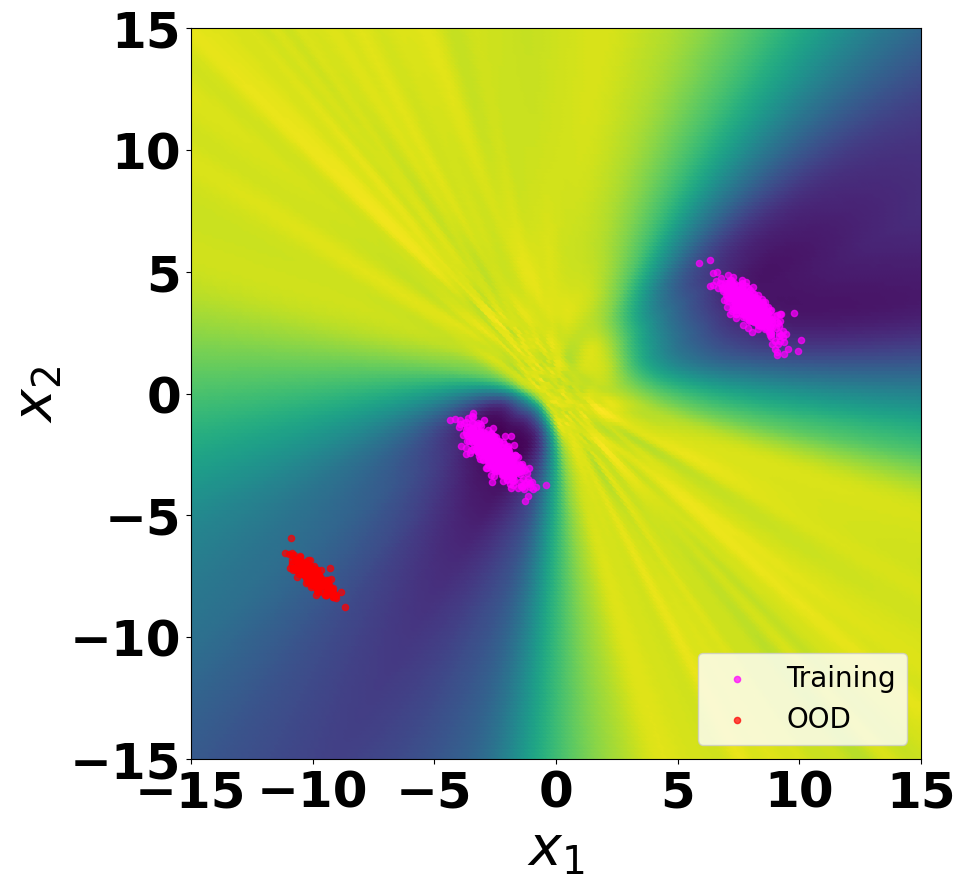

In [21]:
plot_uncertainty_map(x_train, x_ood, x_mesh_full, dnngp_std, model_name, spectral_normalization, False)